In [16]:
import pandas as pd
import re
%matplotlib inline

In [17]:
import glob

In [103]:
from collections import Counter

### Load the texts

Open the files and load the speech into a dataframe

In [18]:
filenames = glob.glob("docs/*.txt.cleaned1.final")

In [19]:
lagebeurteilungen = []

In [20]:
for file in filenames:
    current = {}
    with open(file, 'r') as f:
        text = f.read()
    current['file'] = re.split('/', file)[-1]
    current['text'] = text
    lagebeurteilungen.append(current)

In [21]:
df = pd.DataFrame(lagebeurteilungen)

Add a proper date column

In [22]:
df['date'] = pd.to_datetime(df['file'].str.extract(r'(\d{8})'), format='%Y%m%d')

c:\users\simon\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


In [23]:
df = df.set_index('date')

### Some simple (non-linguistic) analysis

Length of the text

In [24]:
def get_length(row):
    return len(row['text'])

In [25]:
df['length'] = df.apply(get_length, axis=1)

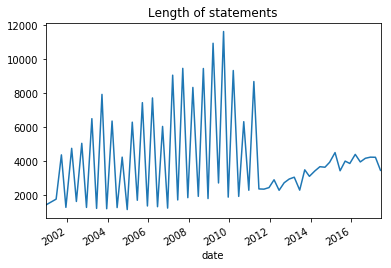

In [26]:
df.length.plot(title='Length of statements')

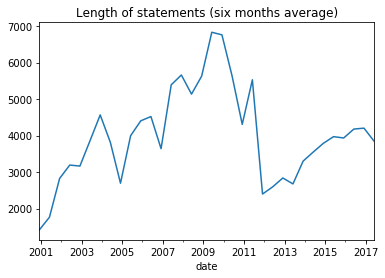

In [27]:
df.resample('6M')['length'].mean().plot(title='Length of statements (six months average)')

Number of words

In [28]:
def get_nowords(row):    
     return len(re.split(' ', row.text))

In [29]:
df['nowords'] = df.apply(get_nowords, axis=1)

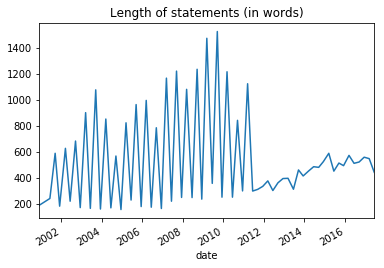

In [30]:
df.nowords.plot(title='Length of statements (in words)')

Number of sentences

In [31]:
def get_nosentences(row):    
     return len(re.split('\D\. ', row.text))

In [32]:
df['nosentences'] = df.apply(get_nosentences, axis=1)

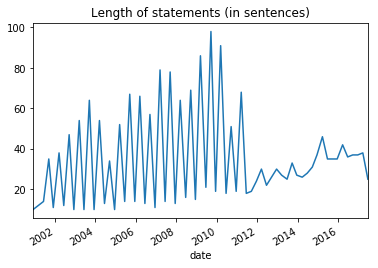

In [33]:
df.nosentences.plot(title='Length of statements (in sentences)')

Words per sentence

In [34]:
df['wordspersentence'] = df['nowords'] / df['nosentences']

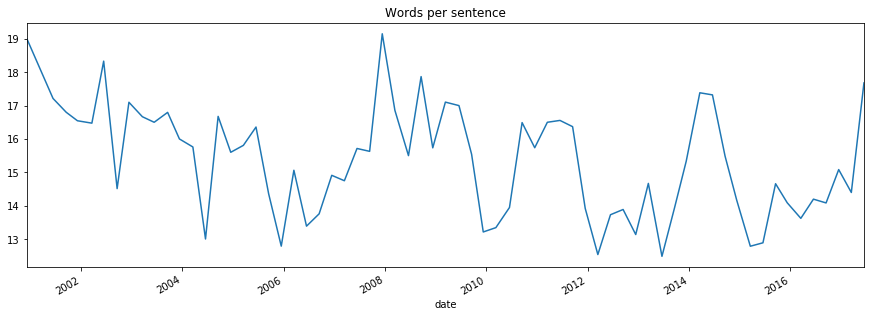

In [35]:
df.wordspersentence.plot(title='Words per sentence', figsize=(15,5))

Word length

In [36]:
df['wordlength'] = (df['length'] - df['nosentences']) / df['nowords'] - 1

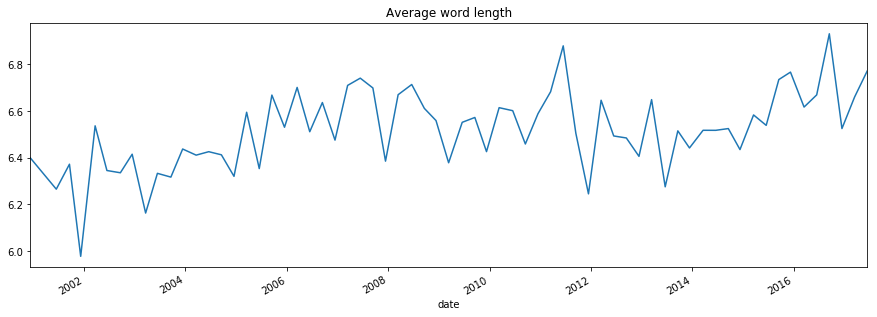

In [37]:
df.wordlength.plot(title='Average word length', figsize=(15,5))

Bla Bla Meter

In [1]:
import requests

In [10]:
from bs4 import BeautifulSoup

In [2]:
url = 'http://www.blablameter.de/index.php'

In [3]:
params = {
    'Text testen': 'Text testen',
    'bc_ip': ''
}

In [40]:
def get_blablameter(row):
    params['bc_ip'] = row['text']
    response = requests.post(url, data=params)
    doc = BeautifulSoup(response.text, "html.parser")
    return doc.find('span', class_='info_index2').text

In [41]:
df['blablameter'] = df.apply(get_blablameter, axis=1)

In [45]:
df['blablameter'] = df['blablameter'].astype(float)

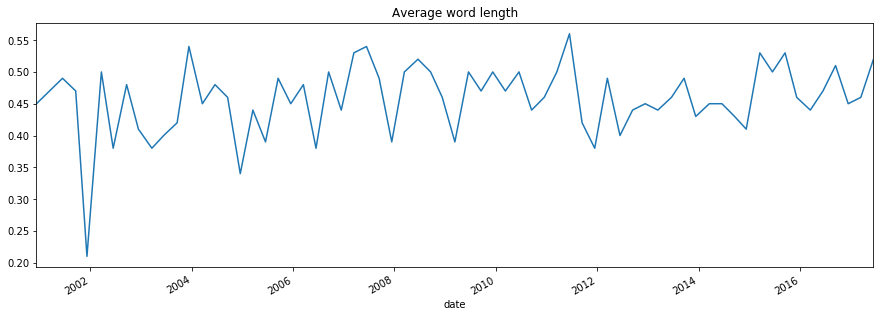

In [46]:
df.blablameter.plot(title='Average word length', figsize=(15,5))

Wordlist in total

In [227]:
with open('wordlists/partikelpronomen.txt', 'r') as f:
    partikel = re.split('\n', f.read())

In [228]:
with open('wordlists/verben.txt', 'r') as f:
    verben = re.split('\n', f.read())

In [229]:
with open('wordlists/partikel2.txt', 'r') as f:
    partikel2 = re.split('\n', f.read())

In [333]:
alltext = ''
for i in df.index:
    alltext = alltext + ' ' + df.loc[i]['text']

In [231]:
wordlist = Counter(re.findall(r'\b[A-ZÄÖÜ][\w-]*\b', alltext))

In [334]:
wordlist = Counter(re.findall(r'\b\w+\b', alltext))

In [335]:
delwords = []
for word in wordlist.keys():
    if re.match(r'\b\d', word):
        delwords.append(word)
for delword in delwords:
    try:
        wordlist.pop(delword)
    except KeyError:
        pass

In [235]:
for partik in partikel:
    try:
        wordlist.pop(partik)
    except KeyError:
        pass

In [236]:
for partik in partikel2:
    try:
        wordlist.pop(partik)
    except KeyError:
        pass

In [237]:
for verb in verben:
    try:
        wordlist.pop(verb)
    except KeyError:
        pass

In [336]:
sortedwordlist = sorted(wordlist.items(), key=lambda x: x[1], reverse=True)

In [337]:
sortedwordlist

[('die', 1542),
 ('der', 1452),
 ('Die', 831),
 ('und', 648),
 ('den', 562),
 ('Nationalbank', 533),
 ('von', 489),
 ('in', 485),
 ('im', 484),
 ('sich', 459),
 ('auf', 430),
 ('für', 375),
 ('des', 340),
 ('das', 321),
 ('zu', 316),
 ('ist', 266),
 ('mit', 259),
 ('bei', 246),
 ('wird', 211),
 ('Libor', 206),
 ('einer', 206),
 ('Dreimonats', 202),
 ('hat', 199),
 ('eine', 191),
 ('Quartal', 191),
 ('weiterhin', 169),
 ('Wachstum', 167),
 ('einem', 163),
 ('dem', 159),
 ('dass', 158),
 ('Jahr', 149),
 ('Inflationsprognose', 144),
 ('als', 143),
 ('Inflation', 135),
 ('Sie', 134),
 ('um', 134),
 ('Entwicklung', 130),
 ('über', 130),
 ('Schweiz', 128),
 ('Prognose', 127),
 ('Für', 126),
 ('aus', 126),
 ('Geldpolitik', 124),
 ('bleibt', 123),
 ('Der', 120),
 ('erwartet', 117),
 ('nach', 116),
 ('werden', 115),
 ('an', 115),
 ('bis', 114),
 ('nicht', 106),
 ('unverändert', 104),
 ('wie', 104),
 ('sie', 102),
 ('In', 101),
 ('Konjunktur', 100),
 ('dürfte', 99),
 ('auch', 97),
 ('Franken', 9

In [239]:
df_wordlist = pd.DataFrame(sortedwordlist, columns=['word', 'count'])

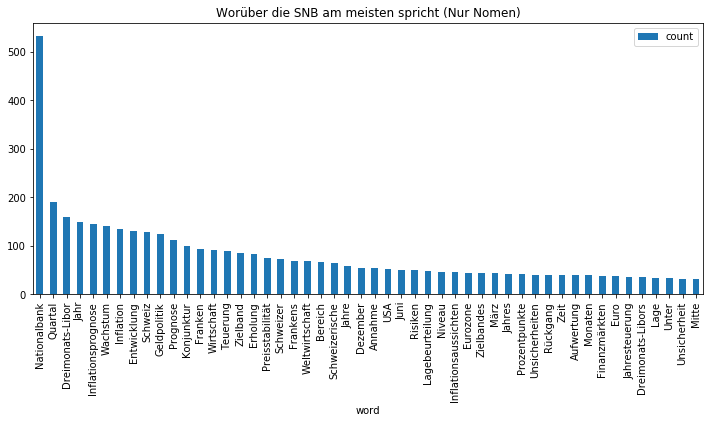

In [240]:
df_wordlist.head(50).plot(kind="bar", x='word', title="Worüber die SNB am meisten spricht (Nur Nomen)", figsize=(12,5))

In [241]:
#nouns = Counter(re.findall(r'\b[A-ZÄÖÜ]\w*\b', alltext))

In [242]:
#sortednouns = sorted(nouns.items(), key=lambda x: x[1], reverse=True)

In [243]:
#df_nouns = pd.DataFrame(sortednouns, columns=['word', 'count'])

In [244]:
#df_nouns.head(50).plot(kind="bar", x='word', title="Worüber die SNB am meisten spricht", figsize=(12,5))

Wordlist per textrow

In [263]:
def get_wordlist(row):
    wordlist = Counter(re.findall(r'\b\w[\w-]*\b', row['text']))
    return wordlist

In [264]:
df['wordlist'] = df.apply(get_wordlist, axis=1)

In [266]:
df

,file,text,length,nowords,nosentences,wordspersentence,wordlength,wordlist
date,,,,,,,,
2000-12-08,pre_20001208.de.pdf.txt.cleaned1.final,"Die Schweizerische Nationalbank hat im Einvernehmen mit dem Bundesrat beschlossen, ihre gegenwärtige Geldpolitik weiterzuführen. Sie wird das Zielband für den Dreimonate-Libor, das seit dem 15. Juni 2000 3%-4% beträgt, unverändert belassen. Sie beabsichtigt, den Dreimonatssatz bis auf weiteres im mittleren Bereich des Zielbandes zu halten. Die Nationalbank sieht von einer erneuten Verschärfung der Geldpolitik ab, weil keine Anzeichen einer längerfristigen Gefährdung der Preisstabilität erken...",1395,190,10,19.000000,6.289474,"{'Die': 5, 'Schweizerische': 1, 'Nationalbank': 5, 'hat': 1, 'im': 8, 'Einvernehmen': 1, 'mit': 4, 'dem': 3, 'Bundesrat': 1, 'beschlossen': 1, 'ihre': 1, 'gegenwärtige': 1, 'Geldpolitik': 2, 'weiterzuführen': 1, 'Sie': 3, 'wird': 2, 'das': 4, 'Zielband': 1, 'für': 1, 'den': 4, 'Dreimonate-Libor': 1, 'seit': 1, '15': 1, 'Juni': 2, '2000': 4, '3': 3, '4': 1, 'beträgt': 1, 'unverändert': 1, 'belassen': 1, 'beabsichtigt': 1, 'Dreimonatssatz': 1, 'bis': 1, 'auf': 4, 'weiteres': 1, 'mittleren': 1,..."
2001-06-14,pre_20010614.de.pdf.txt.cleaned1.final,"Die Nationalbank hat beschlossen, ihre gegenwärtige Geldpolitik fortzusetzen. Sie lässt das Zielband für den Dreimonate- Libor unverändert bei 2,75% bis 3,75%. Der Dreimonate-Libor soll bis auf weiteres im mittleren Bereich des Zielbandes gehalten werden. Die letzte Anpassung der Geldpolitik erfolgte am 22. März 2001, als das Zielband um 0,25 Prozentpunkte gesenkt wurde. Seither haben sich die wirtschaftlichen Perspektiven in der Schweiz kaum verändert. Die Nationalbank sieht daher zurzeit k...",1738,241,14,17.214286,6.153527,"{'Die': 7, 'Nationalbank': 5, 'hat': 2, 'beschlossen': 1, 'ihre': 2, 'gegenwärtige': 1, 'Geldpolitik': 3, 'fortzusetzen': 1, 'Sie': 1, 'lässt': 1, 'das': 6, 'Zielband': 2, 'für': 4, 'den': 6, 'Dreimonate': 1, 'Libor': 1, 'unverändert': 1, 'bei': 1, '2': 4, '75': 2, 'bis': 2, '3': 2, 'Der': 1, 'Dreimonate-Libor': 1, 'soll': 1, 'auf': 3, 'weiteres': 1, 'im': 5, 'mittleren': 1, 'Bereich': 3, 'des': 1, 'Zielbandes': 1, 'gehalten': 1, 'werden': 1, 'letzte': 1, 'Anpassung': 1, 'der': 9, 'erfolgte'..."
2001-09-17,pre_20010917.de.pdf.txt.cleaned1.final,"Die Schweizerische Nationalbank hat beschlossen, das Zielband für den Dreimonate-Libor um 0,5 Prozentpunkte auf 2,25%- 3,25% zu senken. Der Dreimonate-Libor soll bis auf weiteres im mittleren Bereich des Zielbandes gehalten werden. Um Unsicherheiten an den Finanzmärkten entgegenzutreten, hat die Nationalbank ihre für den 20. September 2001 vorgesehene Lagebeurteilung bereits heute durchgeführt. Die letzte Anpassung des Zielbandes erfolgte am 22. März 2001, als die Nationalbank eine Senkung u...",4307,588,35,16.800000,6.265306,"{'Die': 18, 'Schweizerische': 1, 'Nationalbank': 9, 'hat': 5, 'beschlossen': 1, 'das': 2, 'Zielband': 1, 'für': 6, 'den': 10, 'Dreimonate-Libor': 2, 'um': 4, '0': 5, '5': 2, 'Prozentpunkte': 2, 'auf': 8, '2': 4, '25': 4, '3': 1, 'zu': 7, 'senken': 1, 'Der': 2, 'soll': 2, 'bis': 1, 'weiteres': 1, 'im': 14, 'mittleren': 1, 'Bereich': 2, 'des': 5, 'Zielbandes': 2, 'gehalten': 1, 'werden': 3, 'Um': 1, 'Unsicherheiten': 1, 'an': 4, 'Finanzmärkten': 1, 'entgegenzutreten': 1, 'die': 19, 'ihre': 1, ..."
2001-12-07,pre_20011207.de.pdf.txt.cleaned1.final,"Die Nationalbank hat beschlossen, das Zielband für den Dreimonate-Libor um 0,5 Prozentpunkte auf 1,25% bis 2,25% zu senken. Der Dreimonate-Libor soll bis auf weiteres im mittleren Bereich des Zielbandes gehalten werden. Die Nationalbank hat ihre Geldpolitik bereits vor kurzem zweimal angepasst. Am 17. und am 24. September 2001 senkte sie das Zielband für den Dreimonate-Libor um je 0,5 Prozentpunkte. Die Nationalbank reagierte damals auf den verminderten Preisdruck und auf eine unerwünschte E...",1270,182,11,16.545455,5.917582,"{'Die': 6, 'Nationalbank': 5, 'hat': 3, 'beschlossen': 1, 'das': 5, 'Ziel

When did the SNB talk about...

In [341]:
def get_wordcounts(words):
    wordcounts = []
    for i in df.index:
        current = {}
        current['date'] = i
        for word in words:
            regex = r'\b' + word + r'\w*\b'
            current[word] = len(re.findall(regex, df.loc[i]['text'], re.IGNORECASE))
        wordcounts.append(current)
    df_wordcounts = pd.DataFrame(wordcounts)
    df_wordcounts = df_wordcounts.set_index('date')
    return df_wordcounts

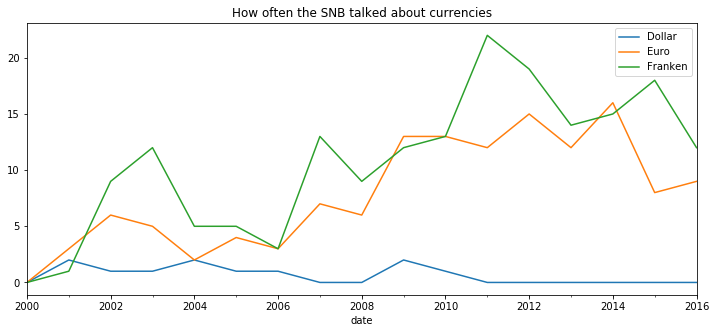

In [342]:
words = ['Franken', 'Euro', 'Dollar']
df_wordcounts = get_wordcounts(words)
df_wordcounts['2000':'2016'].resample('AS').sum().plot(title='How often the SNB talked about currencies', figsize=(12,5))

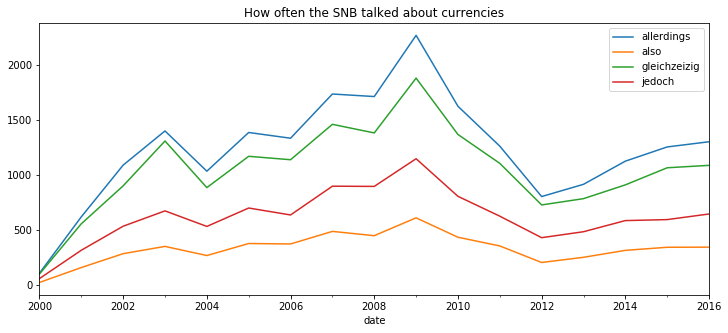

In [345]:
words = ['jedoch', 'allerdings', 'gleichzeizig', 'also']
df_wordcounts = get_wordcount_groups(words)
df_wordcounts['2000':'2016'].resample('AS').sum().plot(title='How often the SNB talked about currencies', figsize=(12,5))

In [343]:
def get_wordcount_groups(wordgroups):
    wordcounts = []
    for i in df.index:
        current = {}
        current['date'] = i
        for wordgroup in wordgroups:
            wordcount = 0
            for word in wordgroup:
                #print (word)
                regex = r'\b' + word + r'\w*\b'
                wordcount = wordcount + len(re.findall(regex, df.loc[i]['text'], re.IGNORECASE))
                #wordcount = 0
            current[str(wordgroup)] = wordcount
        wordcounts.append(current)
    df_wordcounts = pd.DataFrame(wordcounts)
    df_wordcounts = df_wordcounts.set_index('date')
    return df_wordcounts

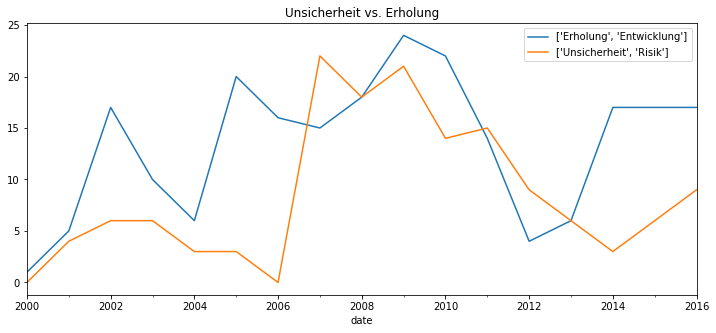

In [347]:
wordgroups = [['Unsicherheit', 'Risik'],['Erholung', 'Entwicklung']]
df_wordcounts = get_wordcount_groups(wordgroups)
df_wordcounts['2000':'2016'].resample('AS').sum().plot(title='Unsicherheit vs. Erholung', figsize=(12,5))

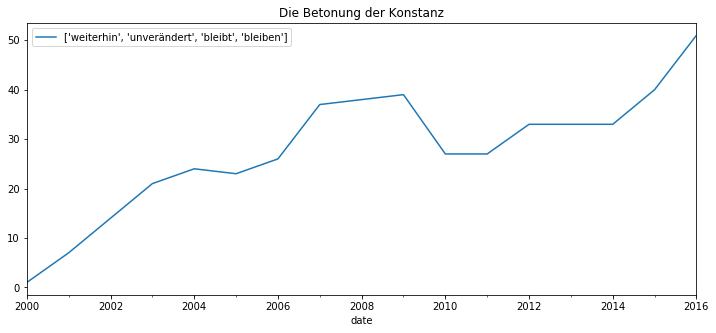

In [346]:
words = [['weiterhin', 'unverändert', 'bleibt', 'bleiben']]
df_wordcounts = get_wordcount_groups(words)
df_wordcounts['2000':'2016'].resample('AS').sum().plot(title='Die Betonung der Konstanz', figsize=(12,5))